# SETUP

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from collections import OrderedDict
from torch.utils.data import Dataset
import os
import time
import yaml
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
!git clone https://github.com/endgameinc/malware_evasion_competition.git
# !wget https://ember.elastic.co/ember_dataset.tar.bz2
import matplotlib.pyplot as plt
import numpy as np
import timeit
import random
from copy import deepcopy
import pickle
from typing import Tuple
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import csv
from sklearn.model_selection import train_test_split

Cloning into 'malware_evasion_competition'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), 92.54 MiB | 5.47 MiB/s, done.
Mounted at /content/gdrive


## Links



*   [random link] https://subscription.packtpub.com/book/security/9781789614671/3/ch03lvl1sec31/malconv-end-to-end-deep-learning-for-malicious-pe-detection
*   [paper + link to paper repo] https://arxiv.org/pdf/1710.09435.pdf https://github.com/j40903272/MalConv-keras 

*   [repo I got the code in this colab from] https://github.com/endgameinc/malware_evasion_competition 

*   [pytorch implementation of MalConv with training loop (no data tho)] https://github.com/Alexander-H-Liu/MalConv-Pytorch 

*   [pytorch implementation with training loop too but they do give insights into how they built their dataset] https://github.com/PowerLZY/MalConv-Pytorch/tree/master
*   [backup dataset. its clean and easy to access but its very big (~8TB)] https://github.com/sophos/SOREL-20M 







In [12]:
class MalConv(nn.Module):
    # trained to minimize cross-entropy loss
    # criterion = nn.CrossEntropyLoss()
    def __init__(self, input_length=2000000, out_size=1, channels=128, window_size=512, embd_size=8, log_stride=None):
        super(MalConv, self).__init__()
        self.embd = nn.Embedding(257, embd_size, padding_idx=0)
        if not log_stride is None:
            stride = 2 ** log_stride
        self.window_size = window_size
    
        self.conv_1 = nn.Conv1d(embd_size, channels, window_size, stride=window_size, bias=True)
        self.conv_2 = nn.Conv1d(embd_size, channels, window_size, stride=window_size, bias=True)
        
        self.pooling = nn.MaxPool1d(int(input_length/window_size))
        
        self.fc_1 = nn.Linear(channels, channels)
        self.fc_2 = nn.Linear(channels, out_size)
      
    def processRange(self, x):
        x = self.embd(x)
        x = torch.transpose(x, -1, -2)

        cnn_value = self.conv_1(x)
        gating_weight = torch.sigmoid(self.conv_2(x))

        x = cnn_value * gating_weight

        return x
    
    def forward(self, x):
        
        x = self.embd(x.long())
        x = torch.transpose(x,-1,-2)
        
        cnn_value = self.conv_1(x)
        gating_weight = torch.sigmoid(self.conv_2(x))
        
        x = cnn_value * gating_weight
        
        x = self.pooling(x)
        
        #Flatten
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        x = F.sigmoid(x)
        
        return x

In [5]:
import torch
import torch.nn.functional as F
import numpy as np

MALCONV_MODEL_PATH = '/content/example_sd_12.model'

malconv = torch.load(MALCONV_MODEL_PATH,map_location=torch.device('cpu'))

def predict_binary(file, model):
  with open(file,'rb') as infile:
    bytez = infile.read()
    return(model.forward(bytez))

## Data wrangling

This series of cells were use to clean up the directory of scraped files from portable freeware. Non .dll/.exe files are removed along with files that do not have \\x## in the beginning.

In [ ]:
!tar -xvf /content/portablefreeware.tar.gz

In [ ]:
!ls /content/content/portablefreeware/ | wc -l

2882


In [ ]:
!find /content/content/portablefreeware/ -not -name '*.dll' -not -name '*.exe' -type f -delete -o -type d -empty -delete


In [ ]:
!ls /content/content/portablefreeware/ | wc -l

2199


In [ ]:
import re
import os
n = 0
a = 0 
for dir in os.listdir("/content/gdrive/MyDrive/hpml_final_project/portablefreeware"):
  a += 1
  
  with open("/content/gdrive/MyDrive/hpml_final_project/portablefreeware/" + dir,'rb') as infile:
    bytez = infile.read()

  if re.search(r"\\x[0-9]{2}", str(bytez[0:5])) != None:
    # print(re.search(r"\\x[0-9]{2}", str(bytez[0:5])))
    n += 1
    with open(f"/content/gdrive/MyDrive/hpml_final_project/portablefreeware2/freeware_{n}"+dir[-4:], "wb") as binary_file:
      print(dir,f"/content/gdrive/MyDrive/hpml_final_project/portablefreeware2/freeware_{n}"+dir[-4:] )
      # Write bytes to file
      binary_file.write(bytez)
  

In [ ]:
!ls /content/gdrive/MyDrive/hpml_final_project/portablefreeware2 | wc -l

1120


In [ ]:
!tar -cvf freeware_execs.tar.gz /content/content/freeware

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!mv /content/freeware_execs.tar.gz /content/gdrive/MyDrive/hpml_final_project

mv: cannot stat '/content/freeware_execs.tar.gz': No such file or directory


## Data loading

This code chunk grabs the cleaned and scraped freeware files, extracts them from the tar, and prints out the file extensions represented in the dataset.

In [ ]:
!cp /content/gdrive/MyDrive/hpml_final_project/freeware_execs.tar.gz /content/

In [ ]:
!mkdir /content/data/

In [ ]:
!cd /content/data/ && tar -xvf ./../freeware_execs.tar.gz 

In [ ]:
!mv /content/data/content/content/freeware /content/data/

In [ ]:
!rm -rf /content/data/content

In [ ]:
# lists all filetypes in dir
!find /content/content/portablefreeware -type f | perl -ne 'print $1 if m/\.([^.\/]+)$/' | sort -u

dll
exe


## Set up dataloaders

This code is based on the paper author's code and it just sets up the dataloaders.

In [7]:
filename = "/content/gdrive/MyDrive/hpml_final_project/input_labels.csv"
X = []
y = []
with open(filename, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\n', quotechar='|')
    first = 0
    for row in spamreader:
      if first == 0:
        first = 1
        continue
      X.append(row[0].split(",")[0])
      y.append(row[0].split(",")[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
test_csv = "/content/gdrive/MyDrive/hpml_final_project/test_labels.csv"
train_csv = "/content/gdrive/MyDrive/hpml_final_project/train_labels.csv"
train_out = []
datapath = "/content/gdrive/MyDrive/hpml_final_project/data_final/"
for i in range(len(y_train)):
  if os.path.isfile(datapath+X_train[i]):
    train_out.append([X_train[i], y_train[i]])
with open(train_csv, 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerows(train_out)
test_out = []
for i in range(len(y_test)):
  if os.path.isfile(datapath+X_test[i]):
    test_out.append([X_test[i], y_test[i]])

with open(test_csv, 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerows(test_out)

def getParams():
    # Format for this is to make it work easily with Optuna in an automated fashion.
    # variable name -> tuple(sampling function, dict(sampling_args) )
    params = {
        'channels': ("suggest_int", {'name': 'channels', 'low': 32, 'high': 1024}),
        'log_stride': ("suggest_int", {'name': 'log2_stride', 'low': 2, 'high': 9}),
        'window_size': ("suggest_int", {'name': 'window_size', 'low': 32, 'high': 512}),
        'embd_size': ("suggest_int", {'name': 'embd_size', 'low': 4, 'high': 64}),
    }
    return OrderedDict(sorted(params.items(), key=lambda t: t[0]))
    
def initModel(**kwargs):
    new_args = {}
    for x in getParams():
        if x in kwargs:
            new_args[x] = kwargs[x]

    return MalConv(**new_args)
  
def write_pred(test_pred,test_idx,file_path):
	test_pred = [item for sublist in test_pred for item in sublist]
	with open(file_path,'w') as f:
		for idx,pred in zip(test_idx,test_pred):
			print(idx.upper()+','+str(pred[0]),file=f)

class ExeDataset(Dataset):
	def __init__(self, fp_list, data_path, label_list, first_n_byte=2000000):
		self.fp_list = fp_list
		self.data_path = data_path
		self.label_list = label_list
		self.first_n_byte = first_n_byte

	def __len__(self):
		return len(self.fp_list)

	def __getitem__(self, idx):
		try:
			with open(self.data_path + self.fp_list[idx],'rb') as f:
				tmp = [i+1 for i in f.read()[:self.first_n_byte]] # index 0 will be special padding index 每个值加一
				tmp = tmp+[0]*(self.first_n_byte-len(tmp))
		except:
			with open(self.data_path + self.fp_list[idx].lower(),'rb') as f:
				tmp = [i+1 for i in f.read()[:self.first_n_byte]]
				tmp = tmp+[0]*(self.first_n_byte-len(tmp))

		return np.array(tmp), np.array([self.label_list[idx]])
config_path = "/content/gdrive/MyDrive/hpml_final_project/example.yaml" 
seed = 10 
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
learning_rate = conf['learning_rate']
max_step = conf['max_step']
test_step = conf['test_step']
batch_size = 1#conf['batch_size']
first_n_byte = conf['first_n_byte']
window_size = conf['window_size']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']
# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)

print("Train Dataloader: " + str(end_train-start_train))

valid_idx = list(val_table.index)
del tr_table
del val_table


malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    pass
    # malconv = malconv.cuda()
    # bce_loss = bce_loss.cuda()
    # sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

Experiment:
	 example_sd_10
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
Train Dataloader: 0.0004053839999755837


# Inference evaluation


In [31]:
#runner function
def get_stats(dataloader, model):
  print(f"Running through the files...")
  
  inference_times = []

  correct_malware = 0 
  total_malware = 0
  correct_freeware = 0 
  total_freeware = 0 
  for x,y in dataloader:
    if total_malware > 150 and total_freeware > 150:
      break

    start = time.perf_counter()
    model_output = model(x)
    elapsed = time.perf_counter()-start
    inference_times.append(elapsed)
    
    prediction = torch.round(model(x))

    if y == 0:
      if prediction == y:
        correct_freeware += 1
      total_freeware +=1
    else:
      if prediction == y:
        correct_malware += 1
      total_malware += 1
    print(f"file processed...  inference time: {(elapsed):0.3f}s")
  resdict = {
           "correct_malware": correct_malware, 
           "correct_freeware": correct_freeware,
           "total_malware": total_malware,
           "total_freeware": total_freeware,
           "inference_times": inference_times}
  return(resdict)

## Baseline model stats

In [ ]:
# LOAD IN MODEL FROM FEDERICO'S TRAINING LOOP

MALCONV_MODEL_PATH = '/content/example_sd_12.model'
malconv = torch.load(MALCONV_MODEL_PATH,map_location=torch.device('cpu'))

baseline_stats = get_stats(dataloader,malconv)

with open('/content/gdrive/MyDrive/hpml_final_project/results/baseline_stats.pickle', 'wb') as handle:
    pickle.dump(baseline_stats, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
malconv

MalConv(
  (embd): Embedding(257, 8, padding_idx=0)
  (conv_1): Conv1d(8, 128, kernel_size=(500,), stride=(500,))
  (conv_2): Conv1d(8, 128, kernel_size=(500,), stride=(500,))
  (pooling): MaxPool1d(kernel_size=4000, stride=4000, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
)

In [80]:
file = open("/content/gdrive/MyDrive/hpml_final_project/results/baseline_stats.pickle", 'rb')
mal_dat = pickle.load(file)
acc = ( mal_dat["correct_malware"] + mal_dat["correct_freeware"] )/( mal_dat["total_malware"] + mal_dat["total_freeware"] )
try:
  mal_acc = mal_dat["correct_malware"]/mal_dat["total_malware"]
except: 
  mal_acc = np.inf
try:
  free_acc = mal_dat["correct_freeware"]/mal_dat["total_freeware"]
except:
  free_acc = np.inf

print(f"total accuracy: { acc *100 :0.2f}, accuracy on malware: {mal_acc * 100 :0.2f}%, accuracy on freeware: {free_acc * 100 :0.2f}%")



param_size = 0
for param in malconv.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in malconv.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb)) #N=300

total accuracy: 69.76, accuracy on malware: 0.66%, accuracy on freeware: 100.00%
model size: 3.979MB


In [81]:
mal_dat

{'correct_malware': 1,
 'correct_freeware': 345,
 'total_malware': 151,
 'total_freeware': 345,
 'inference_times': [0.5715923130001102,
  0.8539950240001417,
  0.9002991359998305,
  0.9238364110001385,
  0.5346834920001129,
  0.5144143850002365,
  0.5361191570000301,
  0.5240261859999009,
  0.5225462630000948,
  0.5070387639998444,
  0.5229416269999092,
  0.5001750219998939,
  0.5064594319997013,
  0.5524996179997288,
  0.602856802000133,
  0.9344545740000285,
  0.8863647110001693,
  0.7562129889997777,
  0.5483985259998008,
  0.5226519930001814,
  0.5114231100001234,
  0.5246838360003494,
  0.5033167910000884,
  0.52706103599985,
  0.49717350800028726,
  0.4739485939999213,
  0.43845041199983825,
  0.5231199299996661,
  0.8356569480001781,
  0.8012586590002684,
  0.9189234430000397,
  0.5279002070001297,
  0.5387352049997389,
  0.5351928320001207,
  0.5315287109997371,
  0.5324254049996853,
  0.5350126030002684,
  0.5305136080000921,
  0.5217345679998289,
  0.5388248569997813,
  0.52

In [34]:
np.mean(mal_dat['inference_times'])

0.620226439657262

In [66]:
base_times = mal_dat['inference_times']

(array([364.,  29.,  74.,  22.,   1.,   2.,   2.,   1.,   0.,   1.]),
 array([0.43845041, 0.59969443, 0.76093844, 0.92218246, 1.08342647,
        1.24467049, 1.4059145 , 1.56715852, 1.72840253, 1.88964655,
        2.05089056]),
 <BarContainer object of 10 artists>)

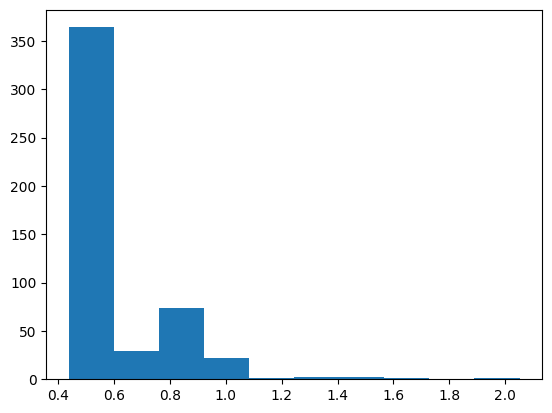

In [65]:
plt.hist(mal_dat['inference_times'])


# MODEL QUANTIZATION

## Copy malconv model

In [35]:
# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv1d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [36]:
malcopy_qweights = copy_model(malconv)
malcopy_qweights

MalConv(
  (embd): Embedding(257, 8, padding_idx=0)
  (conv_1): Conv1d(8, 128, kernel_size=(500,), stride=(500,))
  (conv_2): Conv1d(8, 128, kernel_size=(500,), stride=(500,))
  (pooling): MaxPool1d(kernel_size=4000, stride=4000, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
)

## Store & quantize weights

In [37]:
fc1_weights = malconv.fc_1.weight.data.view(-1)

fc2_weights = malconv.fc_2.weight.data.cpu().view(-1)

cv1_weights = malconv.conv_1.weight.data.cpu().view(-1)

cv2_weights = malconv.conv_1.weight.data.cpu().view(-1)

In [38]:

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    res = torch.clone(weights)
    sc = np.max(np.abs(weights.numpy(force=True))) 
    res = torch.round( res   / (2*sc/(-1+2**8))) 


    return torch.clamp(res, min=-128, max=127), 1/(2*sc/(-1+2**8))

def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to("cpu")

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))



In [39]:
quantize_layer_weights(malcopy_qweights)

## Measure quantized weights model performance

In [ ]:
# LOAD IN MODEL 
# TO DO
qweight_stats = get_stats(dataloader,malcopy_qweights)

with open('/content/gdrive/MyDrive/hpml_final_project/results/qweights_stats.pickle', 'wb') as handle:
    pickle.dump(qweight_stats, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [82]:
file = open("/content/gdrive/MyDrive/hpml_final_project/results/qweights_stats.pickle", 'rb')
mal_dat = pickle.load(file)
acc = ( mal_dat["correct_malware"] + mal_dat["correct_freeware"] )/( mal_dat["total_malware"] + mal_dat["total_freeware"] )
try:
  mal_acc = mal_dat["correct_malware"]/mal_dat["total_malware"]
except: 
  mal_acc = np.inf
try:
  free_acc = mal_dat["correct_freeware"]/mal_dat["total_freeware"]
except:
  free_acc = np.inf

print(f"total accuracy: { acc *100 :0.2f}, accuracy on malware: {mal_acc * 100 :0.2f}, accuracy on freeware: {free_acc * 100 :0.2f}")

param_size = 0
for param in malcopy_qweights.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in malconv.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb)) #N=300

total accuracy: 73.04, accuracy on malware: 0.00, accuracy on freeware: 100.00
model size: 3.979MB


In [50]:
np.mean(mal_dat['inference_times'])

0.620226439657262

In [68]:
q_times = mal_dat['inference_times']

In [83]:
mal_dat

{'correct_malware': 0,
 'correct_freeware': 409,
 'total_malware': 151,
 'total_freeware': 409,
 'inference_times': [1.5885531200001424,
  0.5791946790000111,
  0.5304137329999321,
  0.5189460730002793,
  0.5120459650001976,
  0.5169230999999854,
  0.7807950169999458,
  0.5128733189999366,
  0.5195451690001391,
  0.5093400249998012,
  0.8010557500001596,
  0.7895170830001916,
  0.8221108380002988,
  0.5190550420002182,
  0.48212876500019775,
  0.5315991960001156,
  0.5265896099999736,
  0.5174463659996036,
  0.5282097680001243,
  0.531420283999978,
  0.4979190220001328,
  0.5268564180000794,
  0.5384868179999103,
  0.9443384890000743,
  0.8822243740000886,
  0.8144407159998082,
  0.515472401000352,
  0.5019506990001901,
  0.5178812320000361,
  0.48670612200021424,
  0.5366068509997604,
  0.528551034999964,
  0.49233924200007095,
  0.5215214209997612,
  0.5278435580003134,
  0.5226046160000806,
  0.7474947489999977,
  0.8471274240000639,
  0.8126383450003232,
  0.807249985999988,
  0.54

(array([409.,  31.,  72.,  38.,   2.,   2.,   2.,   1.,   2.,   1.]),
 array([0.42105257, 0.57887416, 0.73669575, 0.89451734, 1.05233894,
        1.21016053, 1.36798212, 1.52580371, 1.6836253 , 1.8414469 ,
        1.99926849]),
 <BarContainer object of 10 artists>)

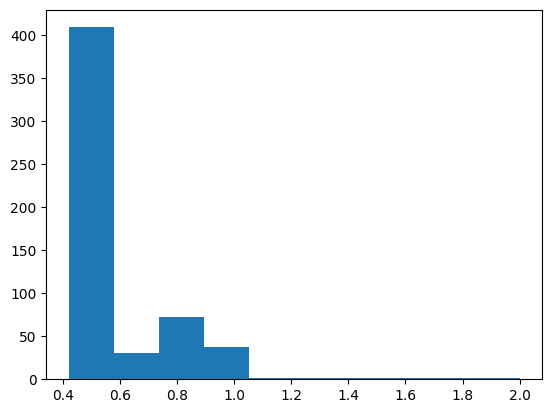

In [63]:
plt.hist(mal_dat['inference_times'])


# TorchScript

In [57]:
my_script_module = torch.jit.script(malcopy_qweights)

In [ ]:
stats = get_stats(dataloader, my_script_module)
with open('/content/gdrive/MyDrive/hpml_final_project/results/script_stats.pickle', 'wb') as handle:
    pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [84]:
file = open("/content/gdrive/MyDrive/hpml_final_project/results/script_stats.pickle", 'rb')
mal_dat = pickle.load(file)
acc = ( mal_dat["correct_malware"] + mal_dat["correct_freeware"] )/( mal_dat["total_malware"] + mal_dat["total_freeware"] )
try:
  mal_acc = mal_dat["correct_malware"]/mal_dat["total_malware"]
except: 
  mal_acc = np.inf
try:
  free_acc = mal_dat["correct_freeware"]/mal_dat["total_freeware"]
except:
  free_acc = np.inf

print(f"total accuracy: { acc *100 :0.2f}, accuracy on malware: {mal_acc * 100 :0.2f}, accuracy on freeware: {free_acc * 100 :0.2f}")

total accuracy: 74.01, accuracy on malware: 0.00, accuracy on freeware: 100.00


In [85]:
mal_dat

{'correct_malware': 0,
 'correct_freeware': 430,
 'total_malware': 151,
 'total_freeware': 430,
 'inference_times': [0.8629682809996666,
  0.6402689250007825,
  0.5314809020001121,
  0.5252511030003006,
  0.5073219739997512,
  0.5224156029998994,
  0.5154452520000632,
  0.5168032980000135,
  0.6958615610001289,
  0.906453823999982,
  0.8673191670004599,
  0.7260374600000432,
  0.5186438519995136,
  0.5241441950001899,
  0.5178580379997584,
  0.5298915949997536,
  0.503945862999899,
  0.5518816619996869,
  0.5202376259994708,
  0.5258234700004323,
  0.5238778410002851,
  0.5624105560000316,
  0.8837276580006801,
  0.8599293799998122,
  0.9267277990002185,
  0.51589548299944,
  0.5364860280005814,
  0.525290892999692,
  0.5709408269995038,
  0.5293604899998172,
  0.5368876309994448,
  0.5241913090003436,
  0.5607277720000639,
  0.516383472000598,
  0.5244040659999882,
  0.9272704479999447,
  0.9095684550002261,
  0.8575522420005655,
  0.5269365909998669,
  0.5434923410002739,
  0.5471362

In [60]:
np.mean(mal_dat['inference_times'])

0.5937246931721042

In [71]:
qscript_times = mal_dat['inference_times']

Text(0, 0.5, 'count')

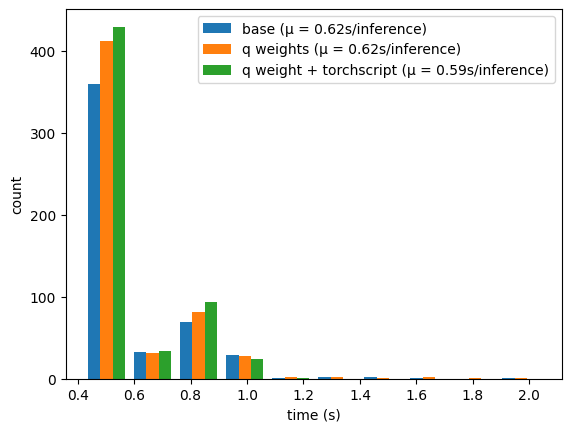

In [79]:
plt.hist([base_times, q_times, qscript_times])
plt.legend(["base (µ = 0.62s/inference)","q weights (µ = 0.62s/inference)", "q weight + torchscript (µ = 0.59s/inference)"])
plt.xlabel("time (s)")
plt.ylabel("count")

In [ ]:
p = 0
N = 0
for i in malconv.parameters():
  print(i.numel())
  N+=i.numel()
  if i.requires_grad:
    p += i.numel()

In [56]:
p # # of trainable model params

1042953

# Misc

In [ ]:
!mv /content/gdrive/MyDrive/hpml_final_project/data/dasmalwerk/* /content/gdrive/MyDrive/hpml_final_project/data/

In [ ]:
!mv /content/gdrive/MyDrive/hpml_final_project/data/portablefreeware/* /content/gdrive/MyDrive/hpml_final_project/data/

In [ ]:
!rm -rf /content/gdrive/MyDrive/hpml_final_project/data/portablefreeware/
!rm -rf /content/gdrive/MyDrive/hpml_final_project/data/dasmalwerk/


In [ ]:
!cp /content/gdrive/MyDrive/hpml_final_project/data/bluetoothview.exe

# GAMEPLAN



1.   Pretrained model experiments
*   Timings
*   Weights, biases, and activations quantization
*   Tracing/scripting
*   Pruning


2.   Training experiments
*   Measurement
*   Hyperparameter sweeping



